In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
import os
import json
import time
import numpy
import pickle
import collections
import PIL
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GRU, SimpleRNN, RNN, Bidirectional

# COLAB ICIN DRIVE KURULUMU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/UCM_captions'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/17YV5WzIlyyzZflEaD_oSy_ecws_h2iam/UCM_captions


In [ ]:
WORKING_DIR = '/content/drive/My Drive/UCM_captions/working'
dataset_folder =  "/content/drive/My Drive/UCM_captions/imgs"
dataset_jsonfile = "/content/drive/My Drive/UCM_captions" + '/dataset.json'

# JUPYTER ICIN VERI SETININ YOLUNUN HAZIRLANMASI

In [ ]:
WORKING_DIR = 'UCM_captions/working'
dataset_folder =  "UCM_captions/imgs"
dataset_jsonfile = "UCM_captions" + '/dataset.json'

# Veri Setinin Hazırlanması

In [ ]:
with open(dataset_jsonfile, 'r') as ds:
    dataset_json = json.load(ds)

In [ ]:
caption_map = collections.defaultdict(list)
for i in dataset_json['images']:
    for j in i['sentences']:
        str = ""
        for k in j['raw']:
            str += k
        caption = f"startseq {str} endseq"
        filename = i['filename'][0:-4]
        img_paths = '%d' % int(filename)
        caption_map[img_paths].append(caption)

# Öznitelik İşlemleri

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input

In [ ]:
feature_extractor = VGG16()

553467096/553467096 [==============================] - 2s 0us/step


In [ ]:
feature_extractor = ResNet152V2()

242745792/242745792 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.models import Model

In [ ]:
feature_extractor = Model(inputs=feature_extractor.inputs, outputs=feature_extractor.layers[-2].output)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
features = {}
directory = dataset_folder

Öznitelik Çıkarma

In [ ]:
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = feature_extractor.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

Öznitelikler Çalışan Dosya Konumuna Kaydedilir

In [ ]:
#Yukarıda Öznitelik Çıkarma Fonksiyonu Çalıştırılmadıysa Bu İki Kod Bloğu Çalıştırılmaz
pickle.dump(features, open(os.path.join(WORKING_DIR, 'featuresVGG.pkl'), 'wb'))

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'featuresResNet.pkl'), 'wb'))

Eğer Kod Baştan Çalıştırılmak İstenirse Öznitelikler Buradan Yüklenebilir, Tekrar Çalıştırılmasına Gerek Yoktur

In [ ]:
with open(os.path.join(WORKING_DIR, 'featuresVGG.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(WORKING_DIR, 'featuresResNet.pkl'), 'rb') as f:
    features = pickle.load(f)

# Captionları Modele Göre Düzenleme

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = " ".join([word for word in caption.split() if len(word)>1])
            captions[i] = caption

In [ ]:
clean(caption_map)

In [ ]:
all_captions = []
for key in caption_map:
    for caption in caption_map[key]:
        all_captions.append(caption)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

23

# Veri Setini Eğitim ve Test Olarak Ayırma ve Rastgele Karıştırma 

In [ ]:
import random
image_ids = list(caption_map.keys())
random.shuffle(image_ids)
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

# Farklı Mimarilerle Oluşturulmuş Modeller



Eğitilmek İstenilen Modelin Kod Bloğu Çalıştırılır

In [ ]:
#nonattention vgg rnn
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = SimpleRNN(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention vgg gru
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention vgg lstm
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention vgg bilstm
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = Bidirectional(LSTM(256))(se2)

# decoder model

decoder1 = Dense(256, activation='relu')(se3)
decoder2 = add([fe2, decoder1])
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention resnet rnn
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = SimpleRNN(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention resnet gru
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonttention resnet lstm
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#nonattention resnet bilstm
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = Bidirectional(LSTM(256))(se2)

# decoder model

decoder1 = Dense(256, activation='relu')(se3)
decoder2 = add([fe2, decoder1])
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention vgg rnn
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = SimpleRNN(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention vgg gru
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention vgg lstm
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention vgg bilstm
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = Bidirectional(LSTM(256))(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention resnet rnn
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = SimpleRNN(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention resnet gru
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention resnet lstm
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#attention resnet bilstm
from tensorflow.keras.layers import Attention
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
attention = Attention(max_length)([decoder1, se3])  # pass query and value tensors
decoder2 = add([decoder1, attention])
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Modelin Eğitimi

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


In [ ]:
epochs = 10
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator 
    generator = data_generator(train, caption_map, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Model Tekrar Kullanılmak İçin Uygun Ad ile Kaydedilebilir

In [ ]:
model.save(WORKING_DIR+'/with_attention_LSTM_ResNet.h5')

Kaydedilen Model Tekrar Eğitilmeden Çalışma Klasöründen Yüklenip Kullanılabilir

In [ ]:
model = tf.keras.models.load_model(WORKING_DIR+'/with_attention_LSTM_Resnet.h5')

# Özet Üretme

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

# Metriklerin Hesaplanması

In [ ]:
!pip install rouge
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = caption_map[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
scores = []
for reference, hypothesis in zip(actual, predicted):
    score = meteor_score(reference, hypothesis)
    scores.append(score)
rouge = Rouge()
rfr = []
rscores = []
for a, (reference, hypothesis) in enumerate(zip(actual, predicted)):
    hstring = ''
    for i in hypothesis:
      hstring += i + ' '
    string = ''
    for i in reference:
      for j in i:
        string += j + ' ' 
    score = rouge.get_scores(string, hstring)
    rscores.append(score)
rouge_l_scores = [score[0]['rouge-l']['f'] for score in rscores]
# calculate the average ROUGE-L score
rougescore = sum(rouge_l_scores) / len(rouge_l_scores)
average_score = sum(scores) / len(scores)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
print("METEOR: %f" % average_score)
print("ROUGE-L: %f" % rougescore)

# Uygulama

Drive'dan Kendi İnputunuzu Ekleyip Özet Üretme

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption_input(image_name):
    img_path = '/content/drive/My Drive/' + image_name
    image_show = Image.open(img_path)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = feature_extractor.predict(image, verbose=0)
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image_show)

Jupyter Üzeirnde Kendi İnputunuzu Ekleyip Özet Üretme

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption_input(image_name):
    img_path =  image_name
    image_show = Image.open(img_path)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = feature_extractor.predict(image, verbose=0)
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image_show)

Veri Setinden Özetleme Üretme

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(dataset_folder, image_name)
    image = Image.open(img_path)
    captions = caption_map[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

Örnekler

--------------------Predicted--------------------
startseq there are some cars on the freeways endseq


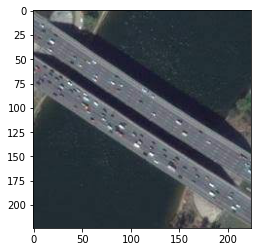

In [ ]:
generate_caption_input('ornek4.jpg')

---------------------Actual---------------------
startseq there are two straight freeways parrallel forward endseq
startseq there are two straight freeways with some plants beside them endseq
startseq two straight freeways parrallel forward with some plants beside them endseq
startseq two straight freeways parrallel forward endseq
startseq two straight freeways parrallel forward with some cars on them endseq
--------------------Predicted--------------------
startseq there are two straight freeways with some plants beside them endseq


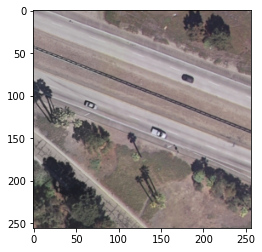

In [ ]:
generate_caption("900.jpg")

---------------------Actual---------------------
startseq there is one road between two buildings endseq
startseq buildings and roads endseq
startseq there are some cars on the road endseq
startseq there are white buildings and lots of cars endseq
startseq the cars parked in orderly rows between the buildings endseq
--------------------Predicted--------------------
startseq there are some buildings with grey and black roofs endseq


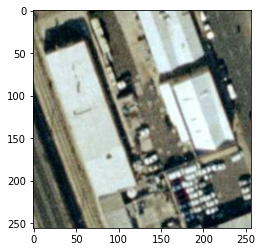

In [ ]:
generate_caption("403.jpg")

---------------------Actual---------------------
startseq an old storage tank is in the lawn endseq
startseq there is an old storage tank in the lawn and some plants beside endseq
startseq an old storage tank is in the lawn and some plants beside endseq
startseq there is an old storage tank in the lawn endseq
startseq an old storage tank is in the lawn and some plants beside endseq
--------------------Predicted--------------------
startseq it is small baseball diamond with sand and grass endseq


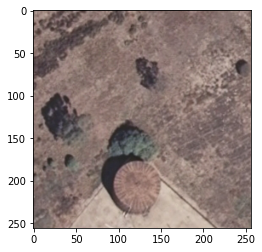

In [ ]:
generate_caption("1972.jpg")

---------------------Actual---------------------
startseq it is river with dense forest on both banks of the river endseq
startseq river with dense forest on both banks of the river endseq
startseq green plants flourish on both banks of the river endseq
startseq lots of green plants flourish on both banks of the river endseq
startseq river go through dense forest endseq
--------------------Predicted--------------------
startseq it is dense forest with some plants on them endseq


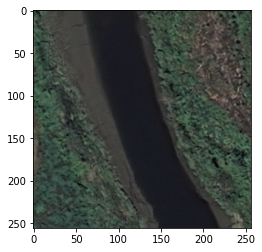

In [ ]:
generate_caption("1689.jpg")